In [1]:
import os
import sys
import numpy as np
from PIL import Image
from skimage import io, img_as_float
from scipy import signal
from skimage.color import rgb2gray
from skimage.transform import resize
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_activ=F.relu):
        super(ConvBlock, self).__init__()
        self.bn = batchnorm
        self.last_activ = last_activ
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)
    def forward(self, x):
        x = self.c1(x)
        if self.bn: x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn: x = self.b2(x)
        x = self.last_activ(x)
        return x

In [5]:
class ContractiveBlock(nn.Module):
    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern, batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern)
        self.d1 = nn.Dropout2d(dropout)
    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))

In [6]:
class ExpansiveBlock(nn.Module):
    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvBlock(out_filters+in_filters2, out_filters, conv_kern)
        
    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin

In [7]:
class Unet(nn.Module):
    def __init__(self, n_labels, n_filters=16, p_dropout=0.5, batchnorm=True):
        super(Unet, self).__init__()
        filter_dict = {}
        filt_pair = [3, n_filters]
        
        for i in range(4):
            self.add_module('contractive_'+str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filter_dict['contractive_'+str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2
        
        self.bottleneck = ConvBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filter_dict['bottleneck'] = (filt_pair[0], filt_pair[1])
        
        for i in reversed(range(4)):
            self.add_module('expansive_'+str(i), ExpansiveBlock(filt_pair[1], filter_dict['contractive_'+str(i)][1], filt_pair[0]))
            filter_dict['expansive_'+str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2
        
        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filter_dict['output'] = (filt_pair[1], n_labels)
        self.filter_dict = filter_dict
    
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)

In [8]:
net = Unet(2).cuda()

In [9]:
net.load_state_dict(torch.load('test.pth'))
net.eval();

In [10]:
def create_patches(image_path):
    im = Image.open(image_path)
    print(im.size)
    new_size = int(256*np.ceil(im.size[0]/256)),int(256*np.ceil(im.size[1]/256))
    print(new_size)
    im = im.resize(new_size)
    im = np.array(im)
    image_patches = []
    for i,x in enumerate(range(0,new_size[1],256)):
        row_patches= []
        for j,y in enumerate(range(0,new_size[0],256)):
            new_im = im[x:x+256,y:y+256]
            row_patches.append(new_im)
        image_patches.append(row_patches)
    return image_patches

In [11]:
data_tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [12]:
def digitize(x,threshold=0.1):
    if x>threshold:
        return min(0.99,2.0*x)
    else:
        return 0.
digitize = np.vectorize(digitize)

In [13]:
def evaluate(image_path, label_path, target_mask):
    patched_image = create_patches(image_path)
    
    full_image = []
    for i, row in enumerate(patched_image):
        row_im = []
        for j, im in enumerate(row):
            img = data_tranform(im).unsqueeze(0).cuda()
            pred = net(img).cpu().detach().numpy()[0][0]
            row_im.append(pred)
        full_image.append(row_im)
    stitch = []
    for i in full_image:
        col_im = []
        for j in i:
            col_im.append(j)
        col_im = np.hstack(col_im)
        stitch.append(col_im)
    stitch = np.vstack(stitch)
    stitch = digitize(stitch)
    
    orig_im = io.imread(image_path)
    manual_mask = img_as_float(rgb2gray(io.imread(label_path)))
    stitch = resize(stitch,(orig_im.shape[0], orig_im.shape[1]),anti_aliasing=True)
    io.imsave(target_mask,stitch)
    diff_im = np.clip(manual_mask-stitch,a_min=0.,a_max=0.99)
    f = plt.figure(figsize=(15,15))
    f.add_subplot(2,2,1)
    plt.imshow(orig_im)
    f.add_subplot(2,2,2)
    plt.imshow(stitch,cmap='gray')
    f.add_subplot(2,2,3)
    plt.imshow(manual_mask,cmap='gray')
    f.add_subplot(2,2,4)
    plt.imshow(diff_im,cmap='gray')

In [14]:
torch.cuda.empty_cache()

(565, 584)
(768, 768)


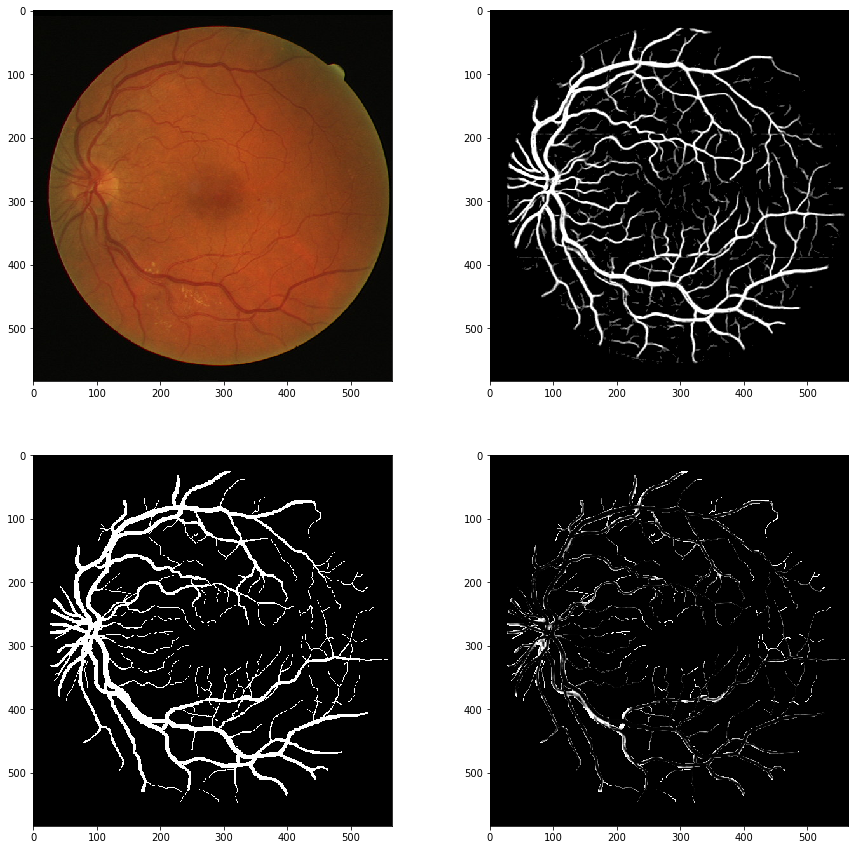

In [15]:
evaluate('DRIVE/test/images/03_test.tif','DRIVE/test/1st_manual/03_manual1.gif', 'data/drive_03.jpg')

(565, 584)
(768, 768)


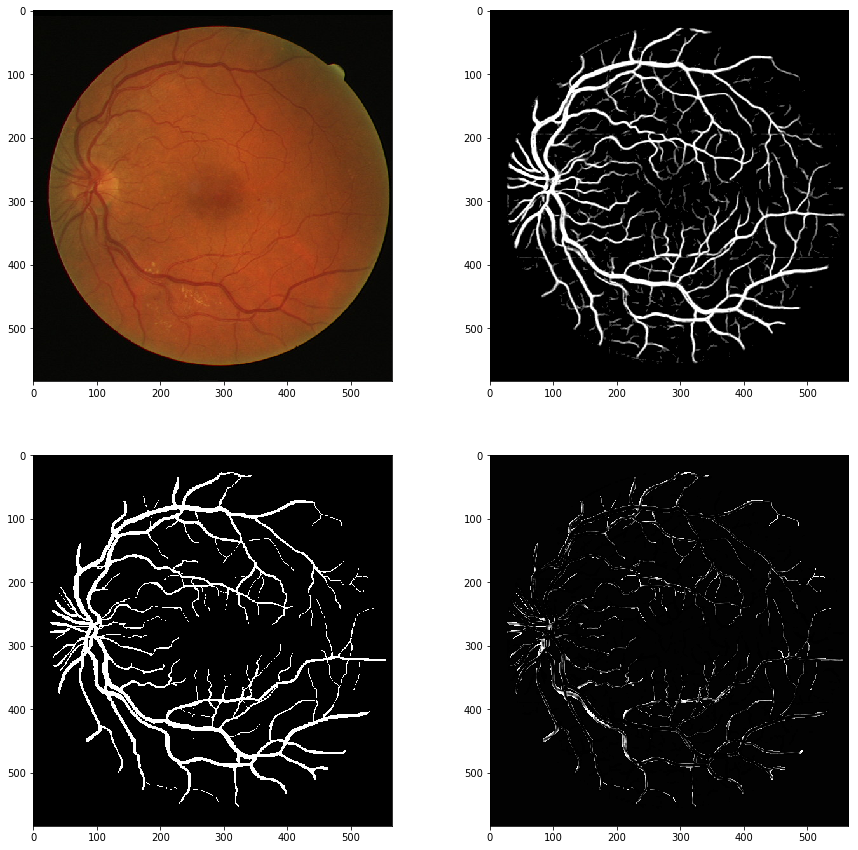

In [16]:
evaluate('DRIVE/test/images/03_test.tif','DRIVE/test/2nd_manual/03_manual2.gif', 'data/drive_03.jpg')

In [17]:
def generate_vessel_map(image_path):
    patched_image = create_patches(image_path)
    
    full_image = []
    for i, row in enumerate(patched_image):
        row_im = []
        for j, im in enumerate(row):
            img = data_tranform(im).unsqueeze(0).cuda()
            pred = net(img).cpu().detach().numpy()[0][0]
            row_im.append(pred)
        full_image.append(row_im)
    stitch = []
    for i in full_image:
        col_im = []
        for j in i:
            col_im.append(j)
        col_im = np.hstack(col_im)
        stitch.append(col_im)
    stitch = np.vstack(stitch)
    stitch = digitize(stitch)
    
    orig_im = io.imread(image_path)
    stitch = resize(stitch,(orig_im.shape[0], orig_im.shape[1]),anti_aliasing=True)
    return stitch

In [18]:
def remove_vessel(channel,mask):
    # coarse adjustments
    box_blur = signal.convolve2d(channel,np.ones((32,32)),boundary='wrap',mode='same')
    box_blur = box_blur/1024
    cured_channel = np.zeros(channel.shape)
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            if (mask[i,j]>0.1):
                cured_channel[i,j] = box_blur[i,j]
            else:
                cured_channel[i,j] = channel[i,j]
    channel = cured_channel
    
    box_blur = signal.convolve2d(channel,np.ones((16,16)),boundary='wrap',mode='same')
    box_blur = box_blur/256
    cured_channel = np.zeros(channel.shape)
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            if (mask[i,j]>0.1):
                cured_channel[i,j] = box_blur[i,j]
            else:
                cured_channel[i,j] = channel[i,j]
    channel = cured_channel
    
    # fine adjustments
    box_blur = signal.convolve2d(channel,np.ones((8,8)),boundary='wrap',mode='same')
    box_blur = box_blur/64
    cured_channel = np.zeros(channel.shape)
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            if (mask[i,j]>0.1):
                cured_channel[i,j] = box_blur[i,j]
            else:
                cured_channel[i,j] = channel[i,j]
    channel = cured_channel
    
    box_blur = signal.convolve2d(channel,np.ones((4,4)),boundary='wrap',mode='same')
    box_blur = box_blur/16
    cured_channel = np.zeros(channel.shape)
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            if (mask[i,j]>0.1):
                cured_channel[i,j] = box_blur[i,j]
            else:
                cured_channel[i,j] = channel[i,j]
    cured_channel
    return cured_channel

In [19]:
def cure_image(orig_im, mask):
    r,g,b = remove_vessel(orig_im[:,:,0],mask),remove_vessel(orig_im[:,:,1],mask),remove_vessel(orig_im[:,:,2],mask)
    cured_image =  np.dstack((r, g, b))
    return cured_image

In [20]:
orig_im = img_as_float(io.imread('DRIVE/test/images/03_test.tif'))
mask = img_as_float(rgb2gray(io.imread('data/drive_03.jpg')))

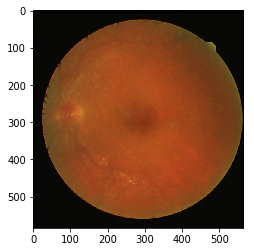

In [21]:
out = cure_image(orig_im,mask)
plt.imshow(out)

In [22]:
def generate_output(image_path, target_dir):
    mask = img_as_float(rgb2gray(generate_vessel_map(image_path)))
    
    orig_im = img_as_float(io.imread(image_path))
    cured_output = cure_image(orig_im,mask)

    image_name = image_path[image_path.rfind('/')+1:]
    image_name = image_name[:image_name.find('.')]
    target_dir = target_dir + image_name + "/"
    os.system("mkdir -p "+ target_dir)
    print (target_dir)
    io.imsave(target_dir + image_name + "_orig.jpg", orig_im)
    io.imsave(fname=target_dir + image_name+"_mask.jpg",arr=mask)
    io.imsave(target_dir + image_name+"_clean.jpg",cured_output)
    return mask,cured_output

In [23]:
image_path = "DRIVE/test/images/20_test.tif"
mask, out = generate_output(image_path, 'data/test_outputs/')

(565, 584)
(768, 768)
data/test_outputs/20_test/


In [25]:
l = os.listdir('data/test_inputs/')
for i in l[:1]:
    generate_output('data/test_inputs/'+i,'data/test_outputs/');

(2048, 1536)
(2048, 1536)
data/test_outputs/Chironx_Camp_Forus_CXA010_0004CR0D/
